In [1]:
import datetime as dt
import pandas as pd
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# 2009-2010 yılı içerisindeki veriler
df_ = pd.read_excel("online_retail.xlsx",sheet_name="Year 2009-2010")
df = df_.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom


In [2]:
#in order to display the Monetary metric, calculate the "Total_Price"
df["Total_Price"]=df["Quantity"]*df["Price"]

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total_Price
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom,30.00


In [4]:
#checking missing value
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
Total_Price         0
dtype: int64

In [5]:
#dropping the missing values
df.dropna(inplace=True)

In [6]:
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
Total_Price    0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417534 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      417534 non-null  object        
 1   StockCode    417534 non-null  object        
 2   Description  417534 non-null  object        
 3   Quantity     417534 non-null  int64         
 4   InvoiceDate  417534 non-null  datetime64[ns]
 5   Price        417534 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      417534 non-null  object        
 8   Total_Price  417534 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.9+ MB


In [8]:
#we need to eliminate invoices which were cancelled
df=df[~df["Invoice"].str.contains("C",na=False)]

In [9]:
#Calculating RFM Metrics
df["InvoiceDate"].max() #2010-12-09, we can assign "today" as '2010-12-11'
today_date=dt.datetime(2010,12,11)

In [10]:
#Calculating RFM Metrics
#Recency, Frequency,Monetary

rfm= df.groupby("Customer ID").agg({"InvoiceDate": lambda x:(today_date-x.max()).days,
                               "Invoice": lambda x: x.nunique(),
                               "Total_Price": lambda x: x.sum()}).reset_index()

In [11]:
rfm.head()

,Customer ID,InvoiceDate,Invoice,Total_Price
0,12346.00,165,11,372.86
1,12347.00,3,2,1323.32
2,12348.00,74,1,222.16
3,12349.00,43,3,2671.14
4,12351.00,11,1,300.93


In [12]:
#Calculating RFM Metrics
rfm.rename(columns={"InvoiceDate": "Recency",
                     "Invoice": "Frequency",
                     "Total_Price": "Monetary"},inplace=True)
rfm.head()

,Customer ID,Recency,Frequency,Monetary
0,12346.00,165,11,372.86
1,12347.00,3,2,1323.32
2,12348.00,74,1,222.16
3,12349.00,43,3,2671.14
4,12351.00,11,1,300.93


In [13]:
#Calculating RFM Metrics
rfm=rfm[rfm["Monetary"]!=0]

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [15]:
rfm_normalized=rfm[["Recency","Frequency"]]

In [16]:
#before using KMeans, we need to get all features in the same scale,
#because KMeans is used based on distance between the data points
scaler=StandardScaler()
rfm_normalized=scaler.fit_transform(rfm_normalized)

In [17]:
rfm_normalized=pd.DataFrame(rfm_normalized)

In [18]:
rfm_normalized.head()

,0,1
0,0.76,0.80
1,-0.91,-0.30
2,-0.18,-0.42
3,-0.50,-0.18
4,-0.83,-0.42


In [19]:
#KMeans Clustering;

ssd=[]
range_n_clusters=range(1,6)
for i in range_n_clusters:
    kmeans=KMeans(n_clusters=i,max_iter=300,random_state=42)
    kmeans.fit(rfm_normalized)
    ssd.append(kmeans.inertia_)


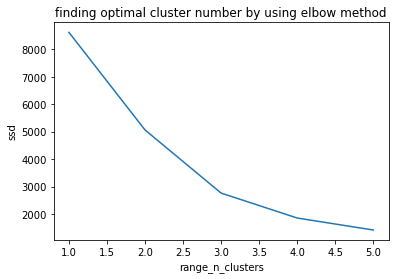

In [20]:
#visualizing clusters with ssd and finding the optimal cluster number
import matplotlib.pyplot as plt

plt.plot(range_n_clusters, ssd)
plt.title("finding optimal cluster number by using elbow method")
plt.xlabel("range_n_clusters")
plt.ylabel("ssd")
plt.show()

In [21]:
#we can use k=3 for optimal cluster number

kmeans=KMeans(n_clusters=3, max_iter=300,random_state=42)
y_means=kmeans.fit_predict(rfm_normalized)

In [22]:
kmeans.labels_

array([1, 0, 0, ..., 1, 0, 0], dtype=int32)

In [23]:
rfm_normalized.loc[:,"CustomerID"]=rfm["Customer ID"]

In [24]:
rfm_normalized.head()

,0,1,CustomerID
0,0.76,0.80,12346.00
1,-0.91,-0.30,12347.00
2,-0.18,-0.42,12348.00
3,-0.50,-0.18,12349.00
4,-0.83,-0.42,12351.00


In [25]:
rfm_normalized["cluster"]=kmeans.labels_

In [26]:
rfm_normalized.head()

,0,1,CustomerID,cluster
0,0.76,0.80,12346.00,1
1,-0.91,-0.30,12347.00,0
2,-0.18,-0.42,12348.00,0
3,-0.50,-0.18,12349.00,0
4,-0.83,-0.42,12351.00,0


In [27]:
import seaborn as sns

In [28]:
rfm_normalized.rename(columns={0: "Recency",
                     1: "Frequency"},inplace=True)
rfm_normalized.head()

,Recency,Frequency,CustomerID,cluster
0,0.76,0.80,12346.00,1
1,-0.91,-0.30,12347.00,0
2,-0.18,-0.42,12348.00,0
3,-0.50,-0.18,12349.00,0
4,-0.83,-0.42,12351.00,0


In [39]:
kmeans.cluster_centers_

array([[-0.50130269,  0.04644554],
       [ 1.56612645, -0.3389946 ],
       [-0.89663404, 11.38275335]])

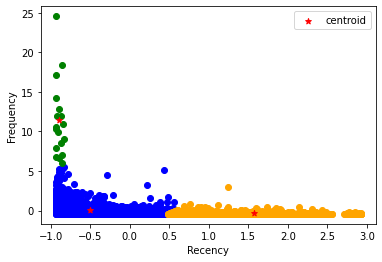

In [41]:
df1=rfm_normalized[rfm_normalized["cluster"]==0]
df2=rfm_normalized[rfm_normalized["cluster"]==1]
df3=rfm_normalized[rfm_normalized["cluster"]==2]

plt.scatter(df1["Recency"],df1["Frequency"], color="blue")
plt.scatter(df2["Recency"],df2["Frequency"], color="orange")
plt.scatter(df3["Recency"],df3["Frequency"], color="green")
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color="red",marker="*",label="centroid")

plt.xlabel("Recency")
plt.ylabel("Frequency")
plt.legend()

<AxesSubplot:xlabel='cluster', ylabel='Frequency'>

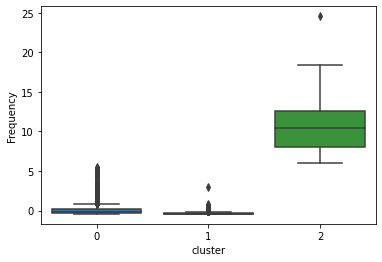

In [36]:
#Last group from the cluster are more frequent customers
sns.boxplot(x="cluster", y="Frequency", data=rfm_normalized)

<AxesSubplot:xlabel='cluster', ylabel='Recency'>

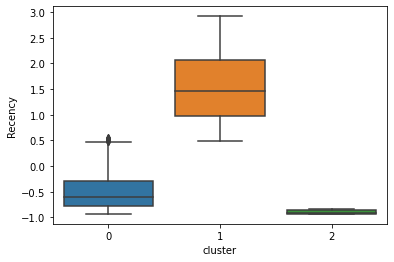

In [37]:
#The less the recent value the recent the customer who bought the products.
#Last group has fewer values
sns.boxplot(x="cluster", y="Recency", data=rfm_normalized)

Cluster 2 --> Best customer, Frequent ve recent shoppers and heavy spendings
Cluster 1 --> Lost customer, low frequency and spending was not placed on recent 
Cluster 0 --> New customers, recent shopper with low frequency and spending
